In [1]:
import pandas as pd
import nltk
from gensim import corpora
import re
import spacy
import pyLDAvis
import pyLDAvis.gensim #dont skip this
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
# Download NLTK resources if you haven't already
nltk.download('punkt')


[nltk_data] Downloading package punkt to C:\Users\Jade
[nltk_data]     Rosales\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
def filter_spoiler_reviews(df):
    return df.drop(df[df['review'] == '[SPOILER ALERT: This review contains spoilers.]'].index)

# Function to categorize the ratings
def categorize_rating(rating):
    if rating <= 5:
        return  'Negative Review'
    else:
        return 'Positive Review'
    
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


<>:15: DeprecationWarning: invalid escape sequence '\['
<>:16: DeprecationWarning: invalid escape sequence '\S'
<>:19: DeprecationWarning: invalid escape sequence '\w'
<>:15: DeprecationWarning: invalid escape sequence '\['
<>:16: DeprecationWarning: invalid escape sequence '\S'
<>:19: DeprecationWarning: invalid escape sequence '\w'
C:\Users\Jade Rosales\AppData\Local\Temp\ipykernel_28560\3971950116.py:15: DeprecationWarning: invalid escape sequence '\['
  text = re.sub('\[.*?\]', '', text)
C:\Users\Jade Rosales\AppData\Local\Temp\ipykernel_28560\3971950116.py:16: DeprecationWarning: invalid escape sequence '\S'
  text = re.sub('https?://\S+|www\.\S+', '', text)
C:\Users\Jade Rosales\AppData\Local\Temp\ipykernel_28560\3971950116.py:19: DeprecationWarning: invalid escape sequence '\w'
  text = re.sub('\w*\d\w*', '', text)


In [4]:
game_df = {}

def process_df(df, filenames):
    df = pd.concat([pd.read_csv(filename) for filename in filenames])
    df = filter_spoiler_reviews(df)
    df['rating'] = df['rating'].apply(categorize_rating)
    df['review'] = df['review'].apply(clean_text)
    return df

filenames_dict = {
    'engage': ['dataset/engage.csv'],
    'threehouses': ['dataset/threehouses.csv'],
    'echoes': ['dataset/echoes.csv'],
    'fates': ['dataset/birthrite.csv', 'dataset/conquest.csv', 'dataset/revelations.csv'],
    'awakening': ['dataset/awakening.csv'],
}

for df_name, filenames in filenames_dict.items():
    game_df[df_name] = process_df(pd.DataFrame(), filenames)


In [5]:
negative_reviews_dict = {}
positive_reviews_dict = {}

for df_name, df in game_df.items():
    negative_reviews_dict[df_name] = df[df['rating'] == 'Negative Review']
    positive_reviews_dict[df_name] = df[df['rating'] == 'Positive Review']

In [7]:
total=0
print('Overall')
for attr, df in game_df.items():  # Assuming game_df is a dictionary
    total += len(df)

print(total)

for attr, df in game_df.items():
    print(attr)
    print('Total Reviews: ',len(df))
    print('Negative Reviews: ',len(negative_reviews_dict[attr]))
    print('Positive Reviews: ',len(positive_reviews_dict[attr]))

engage
Total Reviews:  468
Negative Reviews:  170
Positive Reviews:  298
threehouses
Total Reviews:  987
Negative Reviews:  82
Positive Reviews:  905
echoes
Total Reviews:  95
Negative Reviews:  8
Positive Reviews:  87
fates
Total Reviews:  145
Negative Reviews:  26
Positive Reviews:  119
awakening
Total Reviews:  338
Negative Reviews:  21
Positive Reviews:  317


In [8]:
from nltk.corpus import opinion_lexicon

# # Initialize positive and negative word sets
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

In [9]:
# from gensim.models.keyedvectors import KeyedVectors

# path='GoogleNews-vectors-negative300.bin.gz'
# model = KeyedVectors.load_word2vec_format(path, binary=True)

In [10]:
from gensim.utils import simple_preprocess

# words_to_check = ['gameplay', 'objectives', 'story', 'aesthetics', 'strategy', 'constraints', 'fun',  'boring', 'interactive', 'music', 'audio', 'challenge', 'reward', 'graphics', 'animation', 'level', 'design', 'character', 'challenge', 'theme', 'creative', 'feature', 'style', 'emotional', 'memorable', 'personality', 'map', 'world', 'development']

# similar_words = []
# for word in words_to_check:
#     similar_words.append(model.most_similar(word, topn=10))

# similar_words_list = [item[0] for sublist in similar_words for item in sublist]

# similar_words_list.extend(words_to_check)

nlp = spacy.load('en_core_web_sm', disable=['parser','ner'])

In [11]:
#nlp stopwords
import string

from nltk.corpus import stopwords
stop_words= stopwords.words('english') + list(string.punctuation)
stop_words += list(['fire', 'emblem', 'game','awakening', 'conquest', 'fate', 'birthright', 'revelations', 'echo', 'shadow', 'valentia' ,'three', 'house', 'engage', 'play', 'buy', 'rpg'])
stop_words

# spacy.lang.en.stop_words.STOP_WORDS |= {'fire', 'emblem'}

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [12]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import TfidfModel
from gensim.models import CoherenceModel
from nltk.stem.snowball import SnowballStemmer
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import LsiModel

snow_stemmer = SnowballStemmer(language='english')


def lemmatization(texts,allowed_postags=['NOUN','ADJ','VERB','ADV']):
    """https://spacy.io/api/annotation"""
    data_words=simple_preprocess(str(texts))
    doc=nlp(' '.join(data_words))
    tokens = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if word not in positive_words]
    tokens = [word for word in tokens if word not in negative_words]
    # tokens = [snow_stemmer.stem(token) for token in tokens]

    # gram_tokens = nltk.bigrams(tokens)
    # stemmed_grams = ['_'.join(gram) for gram in gram_tokens]
    # tokens = stemmed_tokens+stemmed_grams
    return tokens

def create_corpus(df):
    # Tokenize the 'Review' column
    tokenized_reviews = df['review'].apply(lemmatization, allowed_postags=['NOUN'])

    # Add n-grams
    phrases = Phrases(tokenized_reviews, min_count=5, threshold=100)
    bigram = Phraser(phrases)
    tokenized_reviews = list(bigram[tokenized_reviews])

    dictionary = Dictionary(tokenized_reviews)

    corpus = [dictionary.doc2bow(text) for text in tokenized_reviews]

    return (corpus, dictionary, tokenized_reviews)

def calc_coherence_values(dictionary, corpus, texts, num_topics=10):
    # Train a LDA model
    model = LdaMulticore(corpus=corpus,id2word = dictionary, num_topics = num_topics, alpha=.1, eta=0.1, random_state = 42)
    print('model created')
    
    # Calculate for the coherence score
    coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
    coherence_value = coherencemodel.get_coherence()
    return model, coherence_value

def calc_coherence_values_Lsi(dictionary, corpus, texts, num_topics=10):
    model = LsiModel(corpus=corpus, id2word = dictionary, num_topics = num_topics)
    print('model created')
    coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
    coherence_values = coherencemodel.get_coherence()
    return model, coherence_values


def tfidf(corpus, dictionary):
    # Train a TF-IDF model
    tfidf = TfidfModel(corpus=corpus)

    # Get TF-IDF weights for each word
    tfidf_corpus = tfidf[corpus]

    # Sort the words by their TF-IDF weights
    words = sorted([(dictionary[word_id], weight) for doc in tfidf_corpus for word_id, weight in doc], key=lambda x: -x[1])


    return tfidf_corpus, words
      

def display_frequent_words(words):
    seen_words = set()
    for word, weight in words:
        if word not in seen_words:
            print(f"{word}: {weight}")
            seen_words.add(word)

In [27]:
# test = get_words(negative_reviews_dict['awakening'])
# # display_frequent_words(test)
# # print(test)
# test

corpus, dict, token = create_corpus(negative_reviews_dict['echoes'])
tfidf_corpus, words = tfidf(corpus, dict)

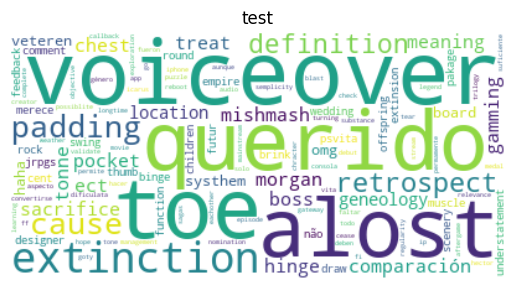

In [42]:
text = {word: value for word, value in words}
wc = WordCloud(background_color="white", max_words=1000)
wc.generate_from_frequencies(text)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("test")
plt.show()

In [28]:
lda_model, coherence_value = calc_coherence_values(dictionary = dict, corpus = tfidf_corpus, texts = token, num_topics=25)
print(coherence_value)

model created
0.5169432167427925


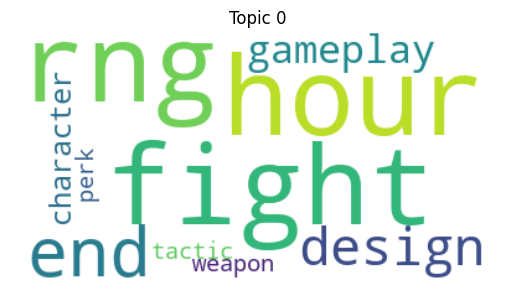

In [30]:
def create_wordcloud(model, topic):
    text = {word: value for word, value in model.show_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic" + " "+ str(topic))
    plt.show()

create_wordcloud(lda_model, topic=0)

In [31]:
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim.prepare(lda_model,corpus,dict,mds='mmds')
vis

c:\Users\Jade Rosales\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12     0.000976  0.021696       1        1  45.128839
5      0.035752 -0.012924       2        1  30.624567
2     -0.028572 -0.005459       3        1   9.388163
23     0.021444  0.014382       4        1   3.898205
16    -0.025014  0.012043       5        1   3.107612
0     -0.014808 -0.020465       6        1   2.089042
15     0.009998 -0.020579       7        1   1.435234
4      0.000013  0.000628       8        1   0.240463
3      0.000013  0.000628       9        1   0.240463
22     0.000013  0.000628      10        1   0.240463
21     0.000013  0.000628      11        1   0.240463
20     0.000013  0.000628      12        1   0.240463
19     0.000013  0.000628      13        1   0.240463
18     0.000013  0.000628      14        1   0.240463
17     0.000013  0.000628      15        1   0.240463
6      0.000013  0.000628      16        1   0.240463
7      0.000013  0.000628      17        1   0.240463
14     0.000013  0.000628      18        1   0.240463
13     0.000013  0.000628      19        1   0.240463
1      0.000013  0.000628      20        1   0.240463
11     0.000013  0.000628      21        1   0.240463
10     0.000013  0.000628      22        1   0.240463
9      0.000013  0.000628      23        1   0.240463
8      0.000013  0.000628      24        1   0.240463
24     0.000013  0.000628      25        1   0.240463, topic_info=          Term      Freq     Total Category  logprob  loglift
148       type  3.000000  3.000000  Default  30.0000  30.0000
105      class  3.000000  3.000000  Default  29.0000  29.0000
85        unit  3.000000  3.000000  Default  28.0000  28.0000
62        item  3.000000  3.000000  Default  27.0000  27.0000
113  diversity  2.000000  2.000000  Default  26.0000  26.0000
..         ...       ...       ...      ...      ...      ...
80      system  0.004273  1.751662  Topic25  -5.0562   0.0144
5          map  0.004273  2.435874  Topic25  -5.0562  -0.3153
32        idea  0.004273  2.364809  Topic25  -5.0562  -0.2857
35        none  0.004273  2.364853  Topic25  -5.0562  -0.2857
25       thing  0.004273  2.661780  Topic25  -5.0562  -0.4040

[1128 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
10        1  0.638592        act
43        1  0.590949     amount
43        2  0.590949     amount
0         1  0.697267  animation
94        1  0.632360      armor
...     ...       ...        ...
87        2  0.411532     weapon
154       1  0.632361     window
27        1  0.638586      witch
89        1  0.590945       year
89        2  0.590945       year

[155 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 6, 3, 24, 17, 1, 16, 5, 4, 23, 22, 21, 20, 19, 18, 7, 8, 15, 14, 2, 12, 11, 10, 9, 25])

In [18]:
lsi_model, coherence_value = calc_coherence_values_Lsi(dictionary = dict, corpus = tfidf_corpus, texts = token, num_topics=14)

c:\Users\Jade Rosales\AppData\Local\Programs\Python\Python311\Lib\site-packages\gensim\models\lsimodel.py:963: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(


model created


In [19]:
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim.prepare(lda_model,corpus,dict)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
22    -0.056760 -0.012462       1        1  31.895047
21     0.040054 -0.037792       2        1  18.620195
14     0.008785  0.016619       3        1  14.100844
1      0.008694  0.014194       4        1   9.364928
24    -0.016579 -0.015471       5        1   5.044457
10     0.010474  0.022276       6        1   4.673497
7      0.001097  0.008473       7        1   2.773489
15     0.003114 -0.004555       8        1   2.105437
0     -0.000482  0.007895       9        1   2.105414
17     0.003966  0.003789      10        1   1.307845
19    -0.005618 -0.000528      11        1   1.306140
2      0.007870  0.003758      12        1   1.223732
16     0.000870  0.004112      13        1   0.595664
9     -0.000457 -0.000859      14        1   0.406943
8     -0.000457 -0.000859      15        1   0.406943
11    -0.000457 -0.000859      16        1   0.406943
6     -0.000457 -0.000859      17        1   0.406943
13    -0.000457 -0.000859      18        1   0.406943
5     -0.000457 -0.000859      19        1   0.406943
4     -0.000457 -0.000859      20        1   0.406943
18    -0.000457 -0.000859      21        1   0.406943
20    -0.000457 -0.000859      22        1   0.406943
3     -0.000457 -0.000859      23        1   0.406943
23    -0.000457 -0.000859      24        1   0.406943
12    -0.000457 -0.000859      25        1   0.406943, topic_info=          Term      Freq     Total Category  logprob  loglift
83      people  2.000000  2.000000  Default  30.0000  30.0000
58          op  3.000000  3.000000  Default  29.0000  29.0000
107     acting  3.000000  3.000000  Default  28.0000  28.0000
110      voice  3.000000  3.000000  Default  27.0000  27.0000
4    character  4.000000  4.000000  Default  26.0000  26.0000
..         ...       ...       ...      ...      ...      ...
166      title  0.008634  2.888980  Topic25  -5.4026  -0.3087
38        unit  0.008634  2.695594  Topic25  -5.4026  -0.2394
41        cast  0.008634  2.018282  Topic25  -5.4026   0.0500
95        time  0.008634  2.586827  Topic25  -5.4026  -0.1982
147    balance  0.008634  2.282496  Topic25  -5.4026  -0.0731

[1272 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
107       1  0.591423   acting
167       1  0.396908     ally
0         2  0.524376     area
124       1  0.427972    azula
147       1  0.438117  balance
...     ...       ...      ...
98        3  0.479833      way
99        1  0.380938   weapon
99        3  0.380938   weapon
39        2  0.544716    white
106       1  0.410468  writing

[129 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[23, 22, 15, 2, 25, 11, 8, 16, 1, 18, 20, 3, 17, 10, 9, 12, 7, 14, 6, 5, 19, 21, 4, 24, 13])

In [32]:
for attr, value in negative_reviews_dict.items():
    print('Results for ' + attr)
    corpus, dict, token = create_corpus(value)
    tfidf_corpus, words = tfidf(corpus, dict)
    lda_model, coherence_value = calc_coherence_values(dictionary = dict, corpus = tfidf_corpus, texts = token, num_topics=25)
    print(coherence_value)
    pyLDAvis.enable_notebook()
    vis=pyLDAvis.gensim.prepare(lda_model,corpus,dict,mds='mmds')
    pyLDAvis.save_html(vis, 'results/'+attr+'_negative.html')
    

Results for engage
model created
0.4277507455288692


c:\Users\Jade Rosales\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Results for threehouses
model created
0.4132566742879853


c:\Users\Jade Rosales\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Results for echoes
model created
0.5169432167427925


c:\Users\Jade Rosales\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Results for fates
model created
0.5670336206891622


c:\Users\Jade Rosales\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Results for awakening
model created
0.614321625336969


c:\Users\Jade Rosales\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [33]:
for attr, value in positive_reviews_dict.items():
    print('Results for ' + attr)
    corpus, dict, token = create_corpus(value)
    tfidf_corpus, words = tfidf(corpus, dict)
    lda_model, coherence_value = calc_coherence_values(dictionary = dict, corpus = tfidf_corpus, texts = token, num_topics=25)
    print(coherence_value)
    pyLDAvis.enable_notebook()
    vis=pyLDAvis.gensim.prepare(lda_model,corpus,dict,mds='mmds')
    pyLDAvis.save_html(vis, 'results/'+attr+'_positive.html')

Results for engage
model created
0.48252956692783755


c:\Users\Jade Rosales\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Results for threehouses
model created
0.522967621709117


c:\Users\Jade Rosales\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Results for echoes
model created
0.35758849320071934


c:\Users\Jade Rosales\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Results for fates
model created
0.4238011444343164


c:\Users\Jade Rosales\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Results for awakening
model created
0.4568346056380198


c:\Users\Jade Rosales\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
